## Text Mining of the Product Reviews

### Preparation

#### Read in packages

In [1173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from wordcloud.wordcloud import WordCloud, STOPWORDS
from PIL import Image
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
import gender_guesser.detector as gender
import warnings
warnings.filterwarnings("ignore")
from dask import compute, delayed
import dask.multiprocessing
import multiprocessing
import time
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import six
import statsmodels.api as sm
from sklearn.tree import export_graphviz
import graphviz
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
import yaml
import textstat
from scipy.stats import rankdata

sns.set(style="whitegrid")
plt.style.use('seaborn-deep')

#pd.set_option('display.max_colwidth', 1)
start=time.time()

#### Read in data

Sample product link:

https://www.amazon.com/Microsoft-Natural-Ergonomic-Keyboard-4000/dp/B000A6PPOK/ref=sr_1_3?dchild=1&keywords=Microsoft%2BNatural%2BErgonomic%2BKeyboard%2Bretail&qid=1585149060&sr=8-3&th=1#customerReviews

In [1174]:
df = pd.read_csv("sample.csv")
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop(['asin'], axis = 1, inplace = True)
df = df.rename(columns={'overall': 'rating'})
df.head(3)

,rating,vote,verified,reviewTime,reviewerID,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,"1,113",True,"10 18, 2005",AILCWT1IIP7ZT,{'Style:': ' Retail'},Charles Chen,"As a software developer, I am literally attach...",Best Overall Keyboard to Date,1129593600,NaN
1,5.0,16,True,"10 12, 2005",A300T403J8526F,{'Style:': ' Retail'},T. Becker,"I've had a Natural Keyboard Pro for years, and...",Best keyboard I've used,1129075200,NaN
2,4.0,11,True,"10 5, 2005",AFPGV3IQ9K691,{'Style:': ' Retail'},GDC,"As with most Microsoft products, great hardwar...","Great keyboard, poor software.",1128470400,NaN


In [1175]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 11 columns):
rating            2567 non-null float64
vote              174 non-null object
verified          2567 non-null bool
reviewTime        2567 non-null object
reviewerID        2567 non-null object
style             2554 non-null object
reviewerName      2567 non-null object
reviewText        2567 non-null object
summary           2567 non-null object
unixReviewTime    2567 non-null int64
image             13 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 203.2+ KB


#### Text cleaning & pre-processing

__Tokenization__: Split the text into sentences and the sentences into words. 

__Lowercase__ the words and __remove punctuation__.

Words that have fewer than 3 characters are removed.

All __stopwords__ are removed.

Words are __lemmatized__: words in third person are changed to first person and verbs in past and future tenses are changed into present.

Words are __stemmed__: words are reduced to their root form.

Reference: https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24

In [1176]:
np.random.seed(2018)

import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
stemmer = SnowballStemmer("english")
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from pprint import pprint

import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lliu9\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##### Functions to perform lemmatize and stem preprocessing steps

In [1177]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [1178]:
df.iloc[10]['reviewText']

"Absolutely love this keyboard.  I had an older one and the letters were worn off.  Didn't bother me, but my wife was very pleased when she saw that it had the letters still on the keys.  This keyboard feels great and is just designed so well."

In [1179]:
doc_sample = df.iloc[10]['reviewText']
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
    
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))

original document: 
['Absolutely', 'love', 'this', 'keyboard.', '', 'I', 'had', 'an', 'older', 'one', 'and', 'the', 'letters', 'were', 'worn', 'off.', '', "Didn't", 'bother', 'me,', 'but', 'my', 'wife', 'was', 'very', 'pleased', 'when', 'she', 'saw', 'that', 'it', 'had', 'the', 'letters', 'still', 'on', 'the', 'keys.', '', 'This', 'keyboard', 'feels', 'great', 'and', 'is', 'just', 'designed', 'so', 'well.']


 tokenized and lemmatized document: 
['absolut', 'love', 'keyboard', 'older', 'letter', 'wear', 'bother', 'wife', 'pleas', 'letter', 'key', 'keyboard', 'feel', 'great', 'design']


##### Preprocess the data

In [1180]:
processed_docs = df['reviewText'].map(preprocess)
processed_docs[:10]

0    [softwar, develop, liter, attach, keyboard, ty...
1    [natur, keyboard, year, work, look, home, keyb...
2    [microsoft, product, great, hardwar, poor, sof...
3                                               [love]
4               [version, keyboard, year, save, wrist]
5                                             [pefect]
6    [plug, work, like, champ, keyboard, take, get,...
7                         [instal, year, work, expect]
8    [like, like, split, half, board, like, challen...
9         [type, word, minut, unit, fifth, year, love]
Name: reviewText, dtype: object

##### Bag of words & Filter out infrequent tokens

In [1181]:
dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below = 10, no_above = 0.5, keep_n = 100000)

count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

0 abl
1 actual
2 addit
3 adjust
4 appreci
5 attach
6 avail
7 base
8 begin
9 best
10 better


##### doc2bow
how many words and how many times those words appear in one document

In [1182]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
bow_corpus[10]

bow_doc = bow_corpus[10]
for i in range(len(bow_doc)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc[i][0], 
                                               dictionary[bow_doc[i][0]], 
bow_doc[i][1]))

Word 42 ("feel") appears 1 time.
Word 63 ("key") appears 1 time.
Word 71 ("love") appears 1 time.
Word 88 ("older") appears 1 time.
Word 226 ("design") appears 1 time.
Word 237 ("great") appears 1 time.
Word 322 ("absolut") appears 1 time.
Word 323 ("bother") appears 1 time.
Word 324 ("letter") appears 2 time.
Word 325 ("pleas") appears 1 time.
Word 326 ("wear") appears 1 time.
Word 327 ("wife") appears 1 time.


##### TF-IDF (frequency-inverse document frequency)

how important a word is to a document in a collection or corpus

In [1183]:
tfidf = models.TfidfModel(bow_corpus)
corpus = tfidf[bow_corpus]
for doc in corpus:
    pprint(doc)
    break

[(0, 0.048588227607141064),
 (1, 0.042782959372661813),
 (2, 0.10458954735714728),
 (3, 0.17801144839365607),
 (4, 0.11876180090061192),
 (5, 0.05816732114891534),
 (6, 0.05506821719183935),
 (7, 0.05816732114891534),
 (8, 0.05635896236653023),
 (9, 0.03220725458509641),
 (10, 0.032264276034067785),
 (11, 0.07513295650850198),
 (12, 0.030751981049663018),
 (13, 0.04478797945302068),
 (14, 0.09854429423731974),
 (15, 0.08495129089596926),
 (16, 0.10041435334175791),
 (17, 0.04663756375924501),
 (18, 0.051802262161705206),
 (19, 0.05816732114891534),
 (20, 0.06644060267878009),
 (21, 0.06644060267878009),
 (22, 0.07057625630367695),
 (23, 0.12050983631322006),
 (24, 0.1389336626423974),
 (25, 0.22539886952550592),
 (26, 0.07917637510085442),
 (27, 0.12142806486613555),
 (28, 0.0525479132754105),
 (29, 0.10641962884569169),
 (30, 0.05204627910806362),
 (31, 0.05705360560779422),
 (32, 0.048780324077929475),
 (33, 0.05855988701566892),
 (34, 0.2178649036092766),
 (35, 0.05569821795178502),

### Topic model

##### LDA using Bag of Words

In [1184]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 10, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [1185]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWord: {}'.format(idx, topic))

Topic: 0 
Word: 0.068*"quick" + 0.049*"support" + 0.042*"caus" + 0.037*"store" + 0.033*"tire" + 0.032*"regist" + 0.032*"hold" + 0.031*"includ" + 0.030*"real" + 0.029*"period"
Topic: 1 
Word: 0.105*"qualiti" + 0.070*"tilt" + 0.063*"wife" + 0.048*"link" + 0.042*"near" + 0.036*"adapt" + 0.032*"default" + 0.030*"mistak" + 0.028*"rat" + 0.027*"busi"
Topic: 2 
Word: 0.025*"space" + 0.022*"ergonom" + 0.021*"natur" + 0.020*"feel" + 0.016*"ergo" + 0.016*"year" + 0.014*"love" + 0.014*"replac" + 0.014*"nice" + 0.013*"littl"
Topic: 3 
Word: 0.036*"mous" + 0.034*"wireless" + 0.032*"easi" + 0.031*"quiet" + 0.027*"posit" + 0.025*"perfect" + 0.024*"desk" + 0.023*"regular" + 0.023*"second" + 0.021*"order"
Topic: 4 
Word: 0.022*"work" + 0.021*"microsoft" + 0.018*"key" + 0.018*"like" + 0.016*"button" + 0.015*"time" + 0.014*"comfort" + 0.013*"press" + 0.013*"buy" + 0.012*"problem"
Topic: 5 
Word: 0.091*"thumb" + 0.064*"spill" + 0.048*"lose" + 0.044*"complet" + 0.042*"suggest" + 0.041*"clean" + 0.038*"emai

##### Model Perplexity and Coherence Score

 judge how good a given topic model is

In [1186]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model = lda_model, texts = processed_docs, dictionary = dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.94617890712126

Coherence Score:  0.3832561678525589


#### Optimal number of topics for LDA 

In [1187]:
def compute_coherence_values(dictionary, corpus, texts, limit, start = 2, step = 1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

comment out as execution takes a while

limit = 15; start = 3; step = 1;

model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus, texts=processed_docs, 
                                                        start=start, limit =limit, step=1)

x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.title('Optimal number of topics by LDA model is 5')
plt.savefig("Optimal number of topics.png")

##### Topic proportions as features

In [1188]:
lda_model_5 = gensim.models.ldamodel.LdaModel(corpus = corpus,
                                           id2word = dictionary,
                                           num_topics = 5, 
                                           random_state = 100,
                                           chunksize = 100,
                                           passes = 10,
                                           alpha = 'auto',       
                                           per_word_topics = True)

In [1189]:
props = []
for ind in range(len(corpus)):
    props.append([i[1].round(5) for i in lda_model_5.get_document_topics(corpus[ind])])

In [1190]:
df["Topic1"] = [i[0] for i in props]
df["Topic2"] = [i[1] for i in props]
df["Topic3"] = [i[2] for i in props]
df["Topic4"] = [i[3] for i in props]
df["Topic5"] = [i[4] for i in props]

#### Topics Visualization

In [1191]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_5, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.163372  0.244203       1        1  35.830872
2     -0.149517  0.155547       2        1  25.173834
0      0.240733 -0.225853       3        1  18.897326
1     -0.236189 -0.158556       4        1  13.982876
3     -0.018398 -0.015341       5        1   6.115089, topic_info=    Category       Freq       Term      Total  loglift  logprob
78   Default  69.000000  microsoft  69.000000  30.0000  30.0000
237  Default  53.000000      great  53.000000  29.0000  29.0000
82   Default  56.000000      natur  56.000000  28.0000  28.0000
15   Default  60.000000    comfort  60.000000  27.0000  27.0000
187  Default  61.000000       like  61.000000  26.0000  26.0000
..       ...        ...        ...        ...      ...      ...
690   Topic5   5.978783        pay   6.601554   2.6953  -4.5573
392   Topic5   5.927249      devic   6.551379   2.6943  -4.5660
655   Topic5   5.928180   trackbal   6.552470   2.6943  -4.5658
608   Topic5   5.553853   everyday   6.171171   2.6890  -4.6311
714   Topic5   5.996981      activ   6.668060   2.6883  -4.5543

[208 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         3  0.953557     abl
714       5  0.899812   activ
1         2  0.994860  actual
207       4  0.955633   allow
384       4  0.952062    angl
...     ...       ...     ...
161       3  0.132655   wrist
162       1  0.640863    year
162       2  0.100135    year
162       3  0.260350    year
163       2  0.967972    zoom

[200 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 3, 1, 2, 4])

Topic 1: functionality (work, type, time)
    
Topic 2: user experience (key, like, button, feel, design)

Topic 3: brand and product name (microsoft, nature, comfort, ergonomic)

Topic 4: subjective (great, best, spacebar)

Topic 5: compatibility (mouse, board, perfect, driver, experience)
    

### Features engineering

Som epossible features from literature: `length`, `reviewer identity`, `foreign brand`, `product type`, `extremity (low/high ratings)`,`writing style`, `timeliness`, `spelling errors`, `readability`, `subjectivity`, `rating scores`, ``

#### Convert vote variable to float type

In [1192]:
def cleanvote(df):
    """
    Outputs the votes as numerical values 
    """
    try:
        return float(df['vote'])
    except ValueError:
        return float(df['vote'].replace(',', ''))
    
df['vote'] = df.apply(cleanvote, axis=1)

#### Get the number of associated images

In [1193]:
def imagenum(df):
    """
    Outputs the number of images from the `image` column
    """
    if type(df['image']) == float:
        return 0
    else:
        return len(df['image'])

df['imagenum'] = df.apply(imagenum, axis=1)

#### Get the indicator of being verified or not

In [1194]:
def verified(df):
    """
    Outputs the indicator (1/0) from the `verified` column
    """
    if df['verified'] == True:
        return 1
    else:
        return 0
    
df['verified'] = df.apply(verified, axis=1)

#### Get the indicator of using a real name

One tried approach: named entities extraction

Pbm: cannot tell the real or seemingly-real names

https://towardsdatascience.com/custom-named-entity-recognition-using-spacy-7140ebbb3718

https://spacy.io/usage/linguistic-features#named-entities

Approach: return true if the `revierName` has verfied first names by gender guesser (not unknown in the name database), (middle name), and last name 

https://pypi.org/project/gender-guesser/

In [1195]:
def nameverified(df):
    """
    Output the indicator (1/0) from the `reviewerName` column 
    """
    try:
        parts = df['reviewerName'].split(' ')
        if len(parts) > 2:
            if gender.Detector().get_gender(parts[0]) != 'unknown': 
                return 1
        else:
            return 0
    except AttributeError:
        return 0

df['nameverified'] = df.apply(nameverified, axis=1)
df['nameverified'] = df['nameverified'].fillna(0)

#### Sentiment

In [1196]:
def sentiment(df):
    """
    Outputs the sentiment score for each review
    """
    return analyser.polarity_scores(df['reviewText'])['compound']

df['Sentiment'] = df.apply(sentiment, axis=1)

In [1197]:
# Sentiment scores are positively correlated with the overall rating, but the correlation is not strong
round(np.corrcoef(df['rating'],  df["Sentiment"])[0,1],3)

0.376

In [1198]:
# correlation within the reviews with positive votes
dfnotnull = df[df['vote'].isna()==0]
np.corrcoef(dfnotnull['vote'],  dfnotnull["Sentiment"])[0,1]

0.033122594194551894

#### Length

https://pypi.org/project/textstat/

In [1199]:
def length(df):
    """
    Output the length for each review
    """
    return textstat.lexicon_count(df['reviewText'], removepunct = True)

df['Length'] = df.apply(length, axis=1)

#### Sentence count

In [1200]:
def sentence_count(df):
    """
    Output the number of sentences for each review
    """
    return textstat.sentence_count(df['reviewText'])

df['Sentences'] = df.apply(sentence_count, axis=1)

#### Flesch reading ease score

In [1201]:
def flesch(df):
    """
    Output the Flesch reading ease score for each review
    """
    return textstat.flesch_reading_ease(df['reviewText'])

df['readability'] = df.apply(flesch, axis=1)

#### Number of spelling mistakes

https://www.analyticsvidhya.com/blog/2018/02/natural-language-processing-for-beginners-using-textblob/

In [1202]:
from textblob import TextBlob
 
data = "Natural language is a cantral part of our day to day life, and it's so antresting to work on any problem related to langages."
 
output = TextBlob(df['reviewText'].iloc[0]).correct()
print(output)

Is a software developer, I am literally attached to my keyboard.  In a typical day, I'll spend anywhere between 5-8 hours tying, so it's of critical importance that the keyboard I use is comfortable.  Is most programme and twists can fattest, the Microsoft Go series of keyboard is the best keyboard for prolonged use.

Having used the Go keyboard in some form or another for the past 4 years (most recently, the Tireless Elite set), I must say that this keyboard is a step above.

To begin with, the construction is very solid.  There is far less flex in the plastic and the keyboard as a whole compared to my Tireless Elite.  The wrist pad is made of a nicely texture faut leather material with a tiny bit of adding.  It feels rather unable (not to mention comfortable).  It's a good addition as one of my main grapes with the of ergot keyboard was that it was hard to fit one of those get wrist rests around the curved base of the keyboard.

Compared to previous of keyboard that I've owned, the k

In [1203]:
output.words[100].spellcheck()

[('in', 1.0)]

In [1204]:
from textblob import Word
w = Word('\n\nSizewise')
w.spellcheck()

[('\n\nSizewise', 0.0)]

In [1205]:
df['reviewText'].iloc[0]

'As a software developer, I am literally attached to my keyboard.  On a typical day, I\'ll spend anywhere between 5-8 hours typing, so it\'s of critical importance that the keyboard I use is comfortable.  As most programmers and typists can attest, the Microsoft Ergo series of keyboards is the best keyboard for prolonged use.\n\nHaving used the Ergo keyboards in some form or another for the past 4 years (most recently, the Wireless Elite set), I must say that this keyboard is a step above.\n\nTo begin with, the construction is very solid.  There is far less flex in the plastic and the keyboard as a whole compared to my Wireless Elite.  The wrist pad is made of a nicely textured faux leather material with a tiny bit of padding.  It feels rather durable (not to mention comfortable).  It\'s a good addition as one of my main gripes with the MS ergo keyboards was that it was hard to fit one of those gel wrist rests around the curved base of the keyboard.\n\nCompared to previous MS keyboards

#### Length of Summary

In [1206]:
def summary_length(df):
    """
    Output the length for each review summary
    """
    return textstat.lexicon_count(df['summary'], removepunct = True)

df['SummaryLength'] = df.apply(summary_length, axis=1)

#### Sentiment of Summary

In [1207]:
def summary_sentiment(df):
    """
    Outputs the sentiment score for each review summary
    """
    return analyser.polarity_scores(df['summary'])['compound']

df['SummarySentiment'] = df.apply(summary_sentiment, axis=1)

#### Days since the first review

In [1208]:
df['unixReviewTime'] = pd.to_datetime(df['unixReviewTime'], unit='s')
df['Days'] = df['unixReviewTime'] - df['unixReviewTime'].min()
df['Days'] = [i.days for i in df['Days']]

#### Before/After verified purchase policy

In [1209]:
def verified_option(df):
    """
    Output whether the review was written after the introduction of verified purchase label policy
    """
    if df['unixReviewTime'].date()> datetime(2016, 11, 1).date():
        return 1
    else:
        return 0

df['verified_option'] = df.apply(verified_option, axis=1)
round(100*sum(df['verified_option'])/len(df))

13

#### Styles (Different models)

In [1210]:
df['style'].value_counts()

{'Style:': ' Retail'}      1930
{'Style:': ' Business'}     624
Name: style, dtype: int64

In [1211]:
# This function is useful when there are multiple categories in 'style'
def style(df):
    """
    Output the style of the product
    """
    try:
        if 'Size:' in df['style']:
            return yaml.load(df['style'])['Style:']
    except:
        return 0

#df['style'] = df.apply(style, axis=1)
#df['Retail'] = np.where(df['style'] == "{'Style:': ' Retail'}", 1, 0)
#sum(df['Retail'])

### Re-estimate actual votes (y)

#### Position

In [1212]:
df['vote2'] = df['vote'] .fillna(0.001)

In [1213]:
df['page_index'] = np.ceil((df.index+1)/10)

In [1214]:
vote_by_pst = df.groupby(['page_index'])['vote2'].agg({'vote2':['mean']})
vote_by_pst.columns = ['mean']
vote_by_pst.head()

,mean
page_index,
1.0,114.0007
2.0,0.0010
3.0,0.0010
4.0,0.0010
5.0,0.0010


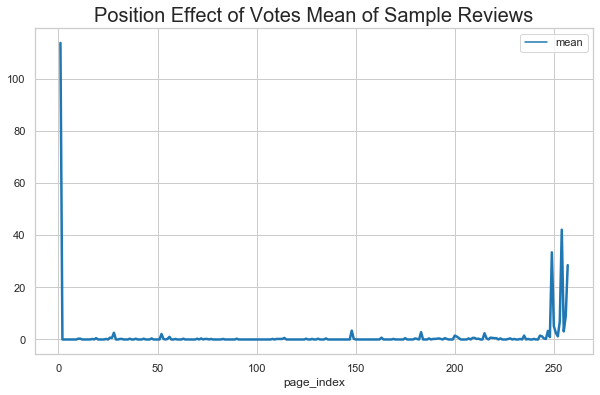

In [1215]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_by_pst, palette="tab10", linewidth=2.5)
plt.title('Position Effect of Votes Mean of Sample Reviews', fontsize=20)
plt.savefig('Plots/Position Effect of Votes Mean of Sample Reviews.png')

#### Time

In [1216]:
df['Quarters'] = np.ceil(df['Days']/90)

In [1217]:
df['Year'] = df['unixReviewTime'].dt.year

In [1218]:
vote_by_yr = df.groupby(['Quarters'])['vote2'].agg({'vote2':['mean', 'count']})
vote_by_yr.columns = ['mean', 'count']
#vote_by_yr['rate'] = (vote_by_yr['mean'] - vote_by_yr['mean'].iloc[0])/vote_by_yr['mean'].iloc[0]
vote_by_yr.head(5)

,mean,count
Quarters,,
0.0,11.000000,1
1.0,137.800000,10
2.0,5.384846,13
3.0,6.667000,6
4.0,5.200200,5


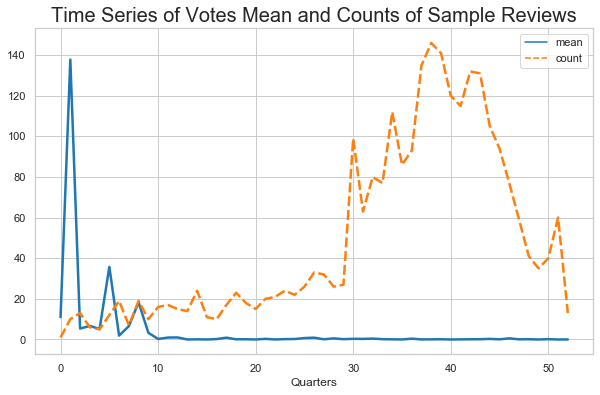

In [1219]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_by_yr, palette="tab10", linewidth=2.5)
plt.title('Time Series of Votes Mean and Counts of Sample Reviews', fontsize=20)
plt.savefig('Plots/Time Series of Votes Mean and Counts of Sample Reviews.png')

#### Bias and correction


Two sources of bias:

1. Time

The reviews range from 2005 to 2018. It is likely older reviews exist in the platform longer and have moe exposures, while the newer reviews are less read by the customers. It is important to re-estimate the actual votes of the reviews by taking the time factor into account.

2. Position

The reviews displayed on top could receive more views and votes.

Model:

$Actual\ vote \propto Current * Quarters * Index $

Intuition: When quarter increases, the votes should increase to compensate for the shorter time of being read. When page index increases, the votes should increase to compensate for the fewer opportuities of being read. 

In [1220]:
vote_re = pd.DataFrame({'vote':df['vote2'], 'Quarter':df['Quarters'], 'Index':df['page_index']})
vote_re = pd.DataFrame(scaler.fit_transform(vote_re), columns=['vote','quarter','index'])
vote_re['vote'] = vote_re['vote']+1e-20  # make the votes no-zero so that the correction rates could have an impat
vote_re

,vote,quarter,index
0,1.000000e+00,0.019231,0.0
1,1.437468e-02,0.019231,0.0
2,9.882309e-03,0.000000,0.0
3,1.000000e-20,1.000000,0.0
4,1.000000e-20,1.000000,0.0
...,...,...,...
2562,9.882309e-03,0.019231,1.0
2563,1.000000e-20,1.000000,1.0
2564,1.000000e-20,1.000000,1.0
2565,1.000000e-20,1.000000,1.0


In [1221]:
vote_re['score'] = vote_re['vote']*(1+vote_re['quarter']+vote_re['index'])

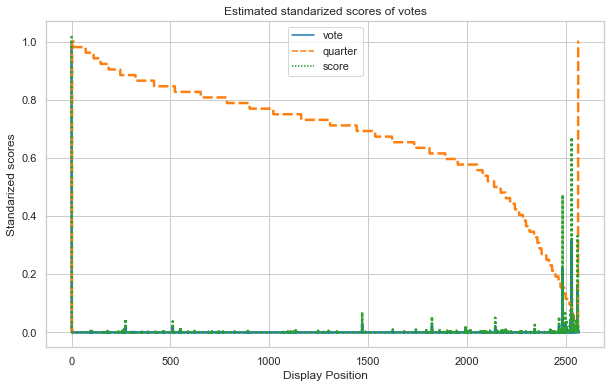

In [1222]:
plt.figure(figsize = (10,6))
sns.lineplot(data=vote_re[['vote', 'quarter', 'score']], palette="tab10", linewidth=2.5)
plt.title('Estimated standarized scores of votes')
plt.xlabel('Display Position')
plt.ylabel('Standarized scores')
plt.savefig('Plots/Estimated Standarized Scores of Votes.png', fontsize=20)

In [1223]:
df['score'] = vote_re['score'].rank()

### Exploratory Data Analysis 

#### Select features by theory

In [1224]:
df.columns

Index(['rating', 'vote', 'verified', 'reviewTime', 'reviewerID', 'style',
       'reviewerName', 'reviewText', 'summary', 'unixReviewTime', 'image',
       'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5', 'imagenum',
       'nameverified', 'Sentiment', 'Length', 'Sentences', 'readability',
       'SummaryLength', 'SummarySentiment', 'Days', 'verified_option', 'vote2',
       'page_index', 'Quarters', 'Year', 'score'],
      dtype='object')

In [1225]:
features = ['rating', 'imagenum', 'nameverified', 'verified',         # objective reviewers' info
            'Topic1', 'Topic2', 'Topic3', 'Topic4', 'Topic5',         # latent topics
            'Sentiment', 'Length', 'Sentences', 'readability',        # characteristics of reviews
            'SummaryLength', 'SummarySentiment']                      # characteristics of reviews summary

#### Summary statistics

In [1226]:
df.drop(['style', 'reviewerID', 'reviewerName', 
         'image', 'reviewTime',], axis=1, inplace=True)

In [1227]:
df[features].describe().round(2)

,rating,imagenum,nameverified,verified,Topic1,Topic2,Topic3,Topic4,Topic5,Sentiment,Length,Sentences,readability,SummaryLength,SummarySentiment
count,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00,2567.00
mean,4.21,0.55,0.08,0.86,0.19,0.14,0.25,0.06,0.36,0.45,81.37,3.12,54.32,5.08,0.27
std,1.21,9.56,0.26,0.34,0.00,0.00,0.01,0.00,0.01,0.54,103.03,3.74,65.76,3.70,0.37
min,1.00,0.00,0.00,0.00,0.18,0.13,0.24,0.06,0.34,-0.99,0.00,1.00,-1108.30,1.00,-0.76
25%,4.00,0.00,0.00,1.00,0.19,0.14,0.25,0.06,0.35,0.14,20.00,1.00,46.44,2.00,0.00
50%,5.00,0.00,0.00,1.00,0.19,0.14,0.25,0.06,0.36,0.64,49.00,2.00,71.48,4.00,0.36
75%,5.00,0.00,0.00,1.00,0.19,0.14,0.25,0.06,0.36,0.88,102.00,4.00,83.66,7.00,0.62
max,5.00,370.00,1.00,1.00,0.21,0.17,0.28,0.08,0.38,1.00,1179.00,41.00,206.84,28.00,0.95


In [1228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2567 entries, 0 to 2566
Data columns (total 26 columns):
rating              2567 non-null float64
vote                174 non-null float64
verified            2567 non-null int64
reviewText          2567 non-null object
summary             2567 non-null object
unixReviewTime      2567 non-null datetime64[ns]
Topic1              2567 non-null float64
Topic2              2567 non-null float64
Topic3              2567 non-null float64
Topic4              2567 non-null float64
Topic5              2567 non-null float64
imagenum            2567 non-null int64
nameverified        2567 non-null float64
Sentiment           2567 non-null float64
Length              2567 non-null int64
Sentences           2567 non-null int64
readability         2567 non-null float64
SummaryLength       2567 non-null int64
SummarySentiment    2567 non-null float64
Days                2567 non-null int64
verified_option     2567 non-null int64
vote2               2

#### Correaltion

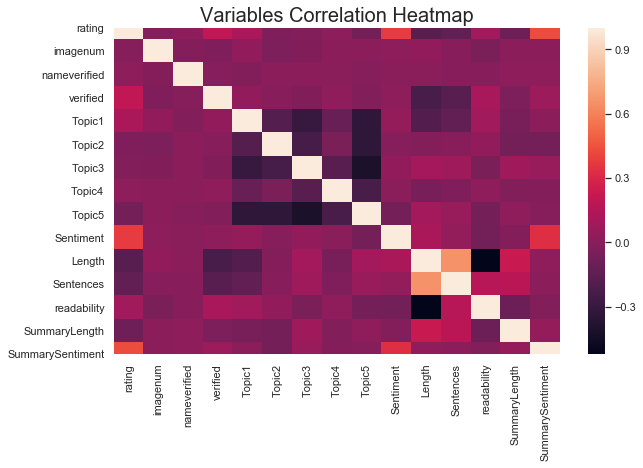

In [1272]:
plt.figure(figsize=(10,6))
sns.heatmap(df[features].corr(), annot=False)
plt.title("Variables Correlation Heatmap", fontsize=20)
plt.savefig('Plots/Variables Correlation Heatmap.png')

#### Rating distributions

In [1230]:
df['rating'].value_counts()

5.0    1562
4.0     464
3.0     206
2.0     179
1.0     156
Name: rating, dtype: int64

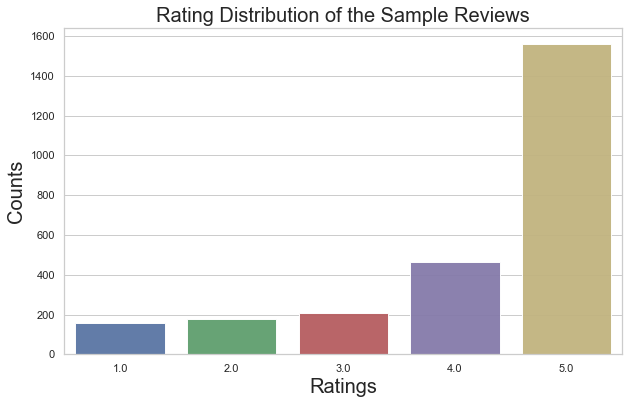

In [1231]:
cnt_rating = df['rating'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(cnt_rating.index, cnt_rating.values, alpha=0.95)
plt.ylabel('Counts', fontsize=20)
plt.xlabel('Ratings', fontsize=20)
plt.xticks(rotation=0)
plt.title('Rating Distribution of the Sample Reviews', fontsize=20)
plt.savefig('Plots/Rating Distribution of the Sample Reviews.png')

#### Verified label

In [1232]:
df['verified'].value_counts()

1    2215
0     352
Name: verified, dtype: int64

In [1233]:
diff = df[features].groupby(['verified']).mean().round(2)
diff

,rating,imagenum,nameverified,Topic1,Topic2,Topic3,Topic4,Topic5,Sentiment,Length,Sentences,readability,SummaryLength,SummarySentiment
verified,,,,,,,,,,,,,,
0,3.59,1.26,0.08,0.19,0.14,0.25,0.06,0.36,0.42,140.30,4.76,35.79,5.44,0.20
1,4.30,0.43,0.07,0.19,0.14,0.25,0.06,0.36,0.46,72.01,2.85,57.27,5.02,0.28


In [1234]:
# Verified reviews have higher average scores
df.groupby(['verified']).mean()['rating']

verified
0    3.593750
1    4.303837
Name: rating, dtype: float64

In [1235]:
# Verified reviews have higher votes
df.groupby(['verified']).mean()['vote']

verified
0     9.294118
1    19.357724
Name: vote, dtype: float64

In [1236]:
df.groupby(['verified']).count()['vote']

verified
0     51
1    123
Name: vote, dtype: int64

#### Time range

In [1237]:
df['unixReviewTime'].min()

Timestamp('2005-10-05 00:00:00')

In [1238]:
df['unixReviewTime'].max()

Timestamp('2018-05-19 00:00:00')

#### Other statistics

In [1239]:
# % of reviews don't have any votes
df['vote'].isna().sum()/df.shape[0]

0.9322165952473704

In [1240]:
# % of reviews don't have images
len(df[df['imagenum']==0])/df.shape[0]

0.9949357226334242

### Export data

In [1241]:
df[features]

,rating,imagenum,nameverified,verified,Topic1,Topic2,Topic3,Topic4,Topic5,Sentiment,Length,Sentences,readability,SummaryLength,SummarySentiment
0,5.0,0,0.0,1,0.18152,0.13299,0.25247,0.05626,0.37677,0.9981,780,1,-703.31,5,0.6369
1,5.0,0,0.0,1,0.21474,0.13793,0.24374,0.05937,0.34421,0.8232,267,1,-182.62,4,0.6369
2,4.0,0,0.0,1,0.17763,0.16719,0.24718,0.05738,0.35063,0.9947,917,15,34.84,4,0.2500
3,5.0,0,0.0,1,0.19793,0.13864,0.24873,0.06086,0.35384,0.6369,2,1,120.21,2,0.0000
4,5.0,0,0.0,1,0.20037,0.13743,0.24683,0.06033,0.35505,0.4753,16,1,80.62,2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.18759,0.14428,0.24900,0.06230,0.35683,0.9287,213,4,42.76,10,-0.4767
2563,5.0,0,0.0,1,0.19704,0.13864,0.24873,0.06174,0.35384,0.4404,1,1,121.22,2,0.0000
2564,5.0,0,0.0,1,0.19064,0.13708,0.24595,0.05860,0.36773,0.4325,82,4,67.59,28,0.8795
2565,5.0,0,0.0,1,0.18627,0.14087,0.26606,0.05957,0.34722,0.2500,32,2,80.62,2,0.5719


In [1242]:
subdf = df[features]
subdf['score'] = df['score']
subdf.to_csv('keyboard_data.csv', index = False)

### Model

In [1243]:
df = pd.read_csv('keyboard_data.csv')

#### Model Class

In [1244]:
df.columns

Index(['rating', 'imagenum', 'nameverified', 'verified', 'Topic1', 'Topic2',
       'Topic3', 'Topic4', 'Topic5', 'Sentiment', 'Length', 'Sentences',
       'readability', 'SummaryLength', 'SummarySentiment', 'score'],
      dtype='object')

In [1245]:
def render_table(data, col_width = 3.0, row_height = 0.625, font_size = 14,
                     header_color = '#40466e', row_colors = ['#f1f1f2', 'w'], edge_color = 'w',
                     bbox = [0, 0, 1, 1], header_columns = 0, ax = None, **kwargs):
    
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText = data.values, bbox = bbox, colLabels = data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight = 'bold', color = 'w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [1246]:
df[features]

,rating,imagenum,nameverified,verified,Topic1,Topic2,Topic3,Topic4,Topic5,Sentiment,Length,Sentences,readability,SummaryLength,SummarySentiment
0,5.0,0,0.0,1,0.18152,0.13299,0.25247,0.05626,0.37677,0.9981,780,1,-703.31,5,0.6369
1,5.0,0,0.0,1,0.21474,0.13793,0.24374,0.05937,0.34421,0.8232,267,1,-182.62,4,0.6369
2,4.0,0,0.0,1,0.17763,0.16719,0.24718,0.05738,0.35063,0.9947,917,15,34.84,4,0.2500
3,5.0,0,0.0,1,0.19793,0.13864,0.24873,0.06086,0.35384,0.6369,2,1,120.21,2,0.0000
4,5.0,0,0.0,1,0.20037,0.13743,0.24683,0.06033,0.35505,0.4753,16,1,80.62,2,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2562,1.0,0,0.0,0,0.18759,0.14428,0.24900,0.06230,0.35683,0.9287,213,4,42.76,10,-0.4767
2563,5.0,0,0.0,1,0.19704,0.13864,0.24873,0.06174,0.35384,0.4404,1,1,121.22,2,0.0000
2564,5.0,0,0.0,1,0.19064,0.13708,0.24595,0.05860,0.36773,0.4325,82,4,67.59,28,0.8795
2565,5.0,0,0.0,1,0.18627,0.14087,0.26606,0.05957,0.34722,0.2500,32,2,80.62,2,0.5719


In [1266]:
class features_selection:
    '''
    This class takes the cleaned review data and apply three ways (random forest, linear regression, lasso regression) for selecting predictive features.
    '''
    def __init__(self, df, rating = 'all'):
        
        self.rating = rating
        self.df = df
        self.out = pd.DataFrame()
 
    def data_preprocessing(self):
        if self.rating == 'all':
            self.df = df
        elif self.rating == 'pos':
            self.df = df[df['rating']>3]
        elif self.rating == 'neg':
            self.df = df[df['rating']<3]
        elif self.rating == 'neu':
            self.df = df[df['rating']==3]
        else:
            print('wrong input')
         
                
        # Select features that capture information that customers would see when reading reviews
        self.X = self.df[features]
        self.y = self.df['score']
        
        #print(self.X.shape, self.y.shape)
        
        # Divide the data into training and test set, with ratio 3:1 (test=20%).
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, random_state = 0)
        # Standarization
        self.X_train = scaler.fit_transform(self.X_train)
        self.X_test = scaler.fit_transform(self.X_test)
        
        self.out["features"] = self.X.columns
        
    def label(self):
        '''
        Return full name for plotting graphs
        '''
        if self.rating == 'all':
            return "for All Reviews in the Sample"
        elif self.rating == 'pos':
            return "for Positive Reviews in the Sample"
        elif self.rating == 'neg':
            return "for Negative Reviews in the Sample"
        elif self.rating == 'neu':
            return "for Neutral Reviews in the Sample"
        else:
            return None
        
    def random_forest(self):
        '''
        Feature importance using Random Forest
        '''
        self.data_preprocessing()
        rfr = RandomForestRegressor(n_estimators = 100, n_jobs = 4).fit(self.X_train, self.y_train)
        imp = pd.DataFrame({"features": self.X.columns, "rfr_select": rfr.feature_importances_})
        imp = imp.sort_values(by='rfr_select', ascending=False)
        imp = imp.round(2)
        
        render_table(imp)
        rfr_title = "Random Forest Feature Importance Results " + self.label()
        plt.title(rfr_title, fontsize=12)
        #plt.savefig("Plots/"+rfr_title)
        plt.close()
        
        self.out['rfr_select'] = rfr.feature_importances_
        self.out['rfr_imp'] = np.where(rankdata(rfr.feature_importances_)>10, 1, 0)
        
        plt.figure(figsize = (12,8))
        plt.hlines(y = imp["features"], xmin = 0, xmax = imp['rfr_select'],
           linestyles = 'dashed', color = 'maroon')

        plt.plot(imp['rfr_select'], imp["features"], ">", color = 'maroon')

        plt.yticks(imp["features"])
        title = "Relative Features Importance by Random Forest " + self.label()
        plt.title(title, loc = 'center', fontsize = 20)
        plt.xlabel('scores')
        plt.savefig("Plots/"+title + '.png')
        plt.close()
        
        
        
    def linear(self):
        '''
        Fit the linear model with Ordinary Least Square
        '''
        self.data_preprocessing()
        lin = LinearRegression().fit(self.X_train, self.y_train)
        linkf = cross_val_score(lin, self.X_train, self.y_train, cv=5, scoring="neg_mean_squared_error")
        #print("Mean:",round(-linkf.mean(),2))
        #print("Standard deviation:",round(linkf.std(),2))
        
        self.X2 = sm.add_constant(self.X_train)
        model = sm.OLS(self.y_train, self.X2).fit()
        #predictions = model.predict(X) 
        print_model = model.summary()
        #print(print_model)
        
        Xcols = [i for i in self.X.columns]
        Xcols.insert(0, 'Intercept')
        output = pd.DataFrame({'Columns':Xcols, 'Coefficients':model.params, 'Std': model.bse, 'p_value':model.pvalues,
                             'Significant at 95% level':np.where(model.pvalues<0.05,1,0)}).round(2)
        
        self.out['linear_select'] = [i for i in model.params[1:]]
        self.out['linear_imp'] = np.where(model.pvalues[1:]<0.05,1,0)
        
        render_table(output)
        linear_title = "Linear Regression Results " + self.label()
        plt.title(linear_title, fontsize=20)
        plt.savefig("Plots/"+linear_title)
        plt.close()
        
        #return [(Xcols[i], model.params[i].round(2))  for i in range(len(Xcols)) if np.where(model.pvalues<0.05,1,0)[i]==1]
    
        
    def lasso(self):
        '''
        Fit the lasso model
        '''
        self.data_preprocessing()
        las = Lasso().fit(self.X_train, self.y_train)
        alpha_grid = {"alpha": np.linspace(0,10,50)}
        grid_search_las = GridSearchCV(las, param_grid = alpha_grid, n_jobs = 4, cv = 5,
                               scoring='neg_mean_squared_error').fit(self.X_train, self.y_train)

        #print('GridBestEstimatorLasso=', grid_search_las.best_estimator_)
        #print('GridBestParamsLasso=', grid_search_las.best_params_)
        #print('GridBestScoreLasso=', -grid_search_las.best_score_)
        
        las = Lasso(alpha = grid_search_las.best_params_['alpha']).fit(self.X_train, self.y_train)
        laskf = cross_val_score(las, self.X_train, self.y_train, cv = 5, 
                              scoring="neg_mean_squared_error")
        #print("Mean:", round(-laskf.mean(),2))
        #print("Standard deviation:",round(laskf.std(),2))
        lasso_output = pd.DataFrame({"features": self.X.columns, "Coefficients": las.coef_}).round(2)
        
        self.out['lasso_select'] = las.coef_
        self.out['lasso_imp'] = np.where(rankdata(np.abs(las.coef_))>10, 1, 0)
        
        render_table(lasso_output)
        lasso_title = "Lasso Regression Results " + self.label()
        plt.title(lasso_title, fontsize=12)
        #plt.savefig("Plots/"+lasso_title)
        plt.close()
        
        ## print lasso path
        ### https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.lasso_path.html
        
        self.nrows, self.ncols = self.X.shape

        eps = 5e-8  # the smaller it is the longer is the path eps = alpha_min / alpha_max = 1e-3

        self.alphas_lasso, self.coefs_lasso, _ = linear_model.lasso_path(self.X_train, self.y_train, eps, fit_intercept=True)

        # Display results
        plt.figure(figsize = (12,8))
        #neg_log_alphas_lasso = -np.log10(alphas_lasso)

        for i in range(self.ncols):
            plt.plot(self.alphas_lasso, self.coefs_lasso[i], label = [i for i in self.X.columns][i])

        plt.xscale('log')
        plt.xlabel('Log($\\lambda$)')
        plt.ylabel('coefficients')
        path_title = "Lasso Path at Different Lambda " + self.label()
        plt.title(path_title, fontsize=20)
        plt.legend()
        plt.axis('tight')  
        plt.savefig("Plots/"+path_title + '.png')
        plt.close()
        
    def output(self):
        self.random_forest()
        self.linear()
        self.lasso()
        self.out['imp_agg'] = self.out['rfr_imp']+self.out['linear_imp']+self.out['lasso_imp']
        self.out = self.out.sort_values(by='imp_agg', ascending=False).round(2)
        
        # correlation (which method correlates most with the majority vote)
        rfr_corr = np.corrcoef(self.out['imp_agg'], self.out['rfr_imp'])[0,1].round(2)
        linear_corr = np.corrcoef(self.out['imp_agg'], self.out['linear_imp'])[0,1].round(2)
        lasso_corr = np.corrcoef(self.out['imp_agg'], self.out['lasso_imp'])[0,1].round(2)
        print("Random Forest:", rfr_corr, "Linear:", linear_corr, "Lasso:", lasso_corr)
    
        return self.out
                          


#### Full data

In [1267]:
df_full = features_selection(df, 'all')
df_full.output()

Random Forest: 0.41 Linear: 0.67 Lasso: 0.86


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.25,1,1291.75,1,2027.14,1,3
0,rating,0.02,0,-284.61,1,-245.21,1,2
8,Topic5,0.09,1,17142.50,0,103.39,1,2
13,SummaryLength,0.07,0,-555.07,1,-333.23,1,2
14,SummarySentiment,0.06,0,240.01,1,176.95,1,2
4,Topic1,0.08,1,14009.33,0,-64.73,0,1
5,Topic2,0.08,1,16028.49,0,-0.00,0,1
6,Topic3,0.09,1,20932.88,0,0.00,0,1
11,Sentences,0.02,0,922.58,1,89.30,0,1
12,readability,0.07,0,-1543.34,1,-0.00,0,1


#### Subset: Positive Reviews

In [1268]:
df_positive = features_selection(df, 'pos')
df_positive.output()

Random Forest: 0.44 Linear: 0.73 Lasso: 0.88


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
10,Length,0.26,1,1077.44,1,1312.93,1,3
8,Topic5,0.09,1,-121669.29,0,325.32,1,2
11,Sentences,0.03,0,892.31,1,594.55,1,2
12,readability,0.07,0,-1322.12,1,-1012.02,1,2
13,SummaryLength,0.08,0,-592.27,1,-546.63,1,2
0,rating,0.01,0,-103.76,1,-101.82,0,1
4,Topic1,0.08,1,-91923.09,0,-95.49,0,1
5,Topic2,0.08,1,-114365.13,0,-5.94,0,1
6,Topic3,0.09,1,-116718.98,0,268.78,0,1
1,imagenum,0.00,0,491.45,0,0.00,0,0


#### Subset: Negative Reviews

In [1269]:
df_negative = features_selection(df, 'neg')
df_negative.output()

Random Forest: 0.59 Linear: 0.45 Lasso: 0.91


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
1,imagenum,0.00,0,1190.32,1,726.48,1,2
5,Topic2,0.09,1,-198110.24,0,437.40,1,2
10,Length,0.25,1,447.24,0,895.60,1,2
12,readability,0.08,1,-1094.81,0,-515.38,1,2
14,SummarySentiment,0.05,0,491.73,1,396.99,1,2
3,verified,0.01,0,-239.21,1,-235.16,0,1
4,Topic1,0.10,1,-180026.46,0,-84.94,0,1
8,Topic5,0.10,1,-231675.28,0,0.00,0,1
0,rating,0.01,0,-47.26,0,-44.67,0,0
2,nameverified,0.00,0,230.61,0,191.34,0,0


#### Subset: Moderate Reviews

In [1270]:
df_moderate = features_selection(df, 'neu')
df_moderate.output()

Random Forest: 0.87 Linear: 0.68 Lasso: 0.72


,features,rfr_select,rfr_imp,linear_select,linear_imp,lasso_select,lasso_imp,imp_agg
13,SummaryLength,0.09,1,-821.81,1,-265.42,1,3
8,Topic5,0.09,1,182434.02,0,219.48,1,2
9,Sentiment,0.10,1,-379.85,1,-160.33,0,2
10,Length,0.26,1,207.49,0,972.48,1,2
3,verified,0.01,0,-215.85,0,-220.54,1,1
7,Topic4,0.09,1,110565.69,0,-125.74,0,1
14,SummarySentiment,0.06,0,521.42,0,256.60,1,1
0,rating,0.00,0,-0.00,0,0.00,0,0
1,imagenum,0.00,0,-0.00,0,0.00,0,0
2,nameverified,0.00,0,-192.97,0,-0.00,0,0


In [1255]:
## Running time
end = time.time()
end - start

160.18780899047852